In [107]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
from itertools import product

# Discrete State 

In [132]:
# Generate an 'all states list' including initial wealth and all unique wealth after all different steps
wealth_list = [1.5,0.5,1.05] # list all wealths after one step (wealth after 1 step: 1 => 1.5(risky asset up), 1 => 0.5(risky asset down), 1 => 1.05(risk-free asset))
outcome_list = [] # list all outcomes(wealths) after all different steps
for i in product(wealth_list, repeat=11):
    outcome_list.append(np.cumprod(i))
state_list = np.unique(outcome_list)
state_list = np.append(state_list,1) # list all states: including initial wealth and all unique wealth after all different steps

In [133]:
# The reward function in terminal
def Reward_func(wealth,risk_aversion):
    return (-math.exp(-risk_aversion*wealth))/risk_aversion

### Environment

In [134]:
# Define the environment
class AssetEnv:
    def __init__(self, p, a, b, rf):
        '''
        The initial function --- receive four parameters
        p: the probability of risk assets going up
        a: increase rate of risky asset
        b: decrease rate of risky asset
        rf: risk-free return
        
        '''
        self.p = p
        self.a = a
        self.b = b
        self.risk_free = rf
        
        self.state_space = state_list # state space includes all discrete wealths (all discrete states)
        self.action_space = [0, 1]  # 0: sell(to hold risk-free asset)，1: buy(to hold risky asset)
        # initialize the state
        self.reset()

    def reset(self):
        self.wealth = 1.0  # initail wealth(state)
        self.t = 0  # initial time step
        self.done = False  # flag whether episode ends
        return self.wealth  # return the current state

    # Execute one step of action
    def step(self, action):
        # If the current episode has ended, then throw an exception
        if self.done:
            raise Exception("Episode is done")
        # If the action is not in action space, then throw an exception
        if action not in self.action_space:
            raise Exception(f"Invalid action: {action}")
        # If sell, then hold the risk-free asset and get a fixed return rate: risk_free
        if action == 0:  # sell
            self.wealth *= 1+self.risk_free
        else:  # buy 
            # If the random number is smaller than probability p, then risky asset goes up
            if np.random.random() < self.p:
                self.wealth *= 1 + self.a
            else:
                self.wealth *= 1 - self.b

        # update the time step
        self.t += 1

        # If time step is larger than or equal to 10, or the wealth is smaller than or equal to 0, then the episode ends
        self.done = self.t >= 10 or self.wealth <= 0

        # Calculate the terminal reward
        reward = 0
        if self.t == 10:
            reward = Reward_func(self.wealth,risk_aversion=1)

        # Return wealth (state), reward, flag whether episode ends
        return self.wealth, reward, self.done

### Q Learning

In [135]:
# QLearning
class QLearningAgent:
    def __init__(self, env, learn_rate=0.1, decay=0.9, epsilon=0.1):
        """
        Initialize QLearning Agent

        :param env: environment
        :param learn_rate: learn rate, range: [0, 1]
        :param decay: decay factor, range: [0, 1]
        :param epsilon: ε-greedy, range: [0, 1]
        """
        self.env = env
        self.learn_rate = learn_rate
        self.decay = decay
        self.epsilon = epsilon
        # Initilize Q table
        self.q = np.zeros((len(env.state_space), len(env.action_space)))

    def act(self, state):
        """
        Given current state(wealth), use ε-greedy and max q-value to select the optimal action

        :return: the selected action
        """
        if np.random.random() < self.epsilon:  # Actions are selected at random with a probability of ε
            return np.random.choice(self.env.action_space)
        else:  # The action with the largest Q value is the optimal action
            state_index = np.where(state_list == state)[0][0]
            return np.argmax(self.q[state_index])
    
    def update(self, state, action, reward, next_state): 
        """
        Update Q

        :param state: current swealth
        :param next_state: next wealth
        """
        next_state_index = np.where(state_list == next_state)[0][0]
        state_index = np.where(state_list == state)[0][0]
        td_error = (
            reward + self.decay * np.max(self.q[next_state_index]) - self.q[state_index, action]
        )
        self.q[state_index, action] += self.learn_rate * td_error

    def train(self, num_episodes):
        """
        Train the QLearningAgent

        :param num_episodes: the number of episodes
        """
        rewards = [] # record reward of each episode
        wealths = [] # record wealth of each episode
        for i in range(num_episodes):
            wealth = self.env.reset()
            done = False
            while not done:
                action = self.act(wealth)
                next_wealth, reward,done = self.env.step(action)
                self.update(wealth, action, reward, next_wealth)
                wealth = next_wealth
            terminal_wealth = wealth
            wealths.append(terminal_wealth)
            rewards.append(reward)
        return wealths, rewards # return the records of wealths and rewards in all episodes

    def get_policy(self):
        """
        Get the optimal policy

        :return the optimal policy
        """
        return np.argmax(self.q, axis=1)

In [136]:
# Train the QLearningAgent
env = AssetEnv(p=0.99, a=0.5, b=0.5, rf=0.05)
model = QLearningAgent(env)
num_episodes = 100000
wealths, rewards = model.train(num_episodes=num_episodes)

Calculate the mean and standard deviation of all elements in the rewards and wealths array respectively.  
The higher the average reward, the better the model performs in the environment.   
The smaller the standard deviation, the more stable the performance of the model in different episodes.

In [137]:
avg_wealth = np.mean(wealths)
std_wealth = np.std(wealths)
avg_reward = np.mean(rewards)
std_reward = np.std(rewards)
print(f"Average wealth: {avg_wealth:.2f}, std: {std_wealth:.2f}")
print(f"Average reward: {avg_reward:.2f}, std: {std_reward:.2f}")


Average wealth: 16.87, std: 5.87
Average reward: -0.00, std: 0.01


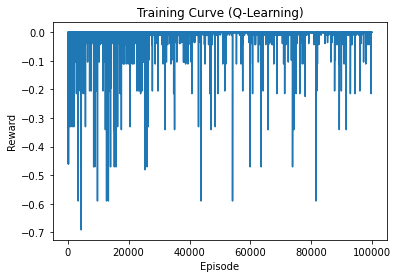

In [138]:
# Evaluation: reward

#Plot the training curve of rewards:
plt.plot(range(1, num_episodes + 1), rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Curve (Q-Learning)")
plt.show()

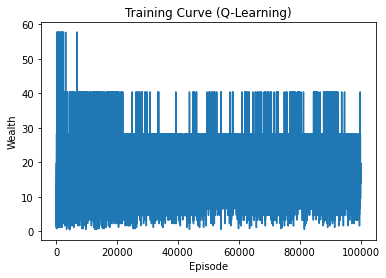

In [139]:
# Evaluation: wealth

#Plot the training curve of wealths:
plt.plot(range(1, num_episodes + 1), wealths)
plt.xlabel("Episode")
plt.ylabel("Wealth")
plt.title("Training Curve (Q-Learning)")
plt.show()

In [140]:
# Print the optimal policy:
policy = model.get_policy()
print("Optimal policy:", policy)

Optimal policy: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0
 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1
 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1
 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 

In [141]:
# Find the wealth index of the policy that chooses to buy risky asset
policy_arr = np.array(policy)
np.where(policy_arr == 1)

(array([201, 208, 211, 219, 220, 227, 229, 239, 243, 247, 257, 261, 262,
        269, 277, 283, 285, 286, 287, 290, 292, 298, 299, 304, 306, 309,
        318, 321, 327, 329, 330, 331, 332, 334, 335, 336, 337, 339, 340,
        341, 342, 344, 345, 347, 348, 349, 352, 353, 354, 355, 363, 372,
        378, 380, 381, 382, 383, 384, 385, 386, 387, 388, 391, 392, 393,
        394, 395, 396, 399, 400, 401, 402, 403, 404, 406, 407, 411, 412,
        415, 423, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
        440, 441, 442, 446, 450, 451, 452, 453, 459, 473, 482, 485, 486,
        487, 488, 489, 490, 492, 493, 494, 495, 496, 498, 500, 504, 521,
        522, 525, 526, 528, 530, 532, 533, 534, 537, 561, 565, 566, 569,
        573, 615, 657], dtype=int64),)

For Q-Learning, each update is the Q value that takes an action in the current state,
while TD(lambda) updates the value function of the current state.  
In addition, TD(lambda) uses Eligibility Traces to track the frequency of access to each state,
thus weighing the contributions of current and previous states to value functions.  
Q-learning does not use Eligibility Traces.  
Then Sarsa let agent to learn Q(s,a) instead of V(s), and become an on-policy TD control method: Sarsa(lambda).  

In [142]:
# Sarsa(lambda)
class SarsaLambdaAgent:
    def __init__(self, env, learn_rate=0.1, decay=0.9, epsilon=0.1, lambd=0.5):
        """
        Initialize Sarsa(Lambda) Agent

        :param env: environment
        :param learn_rate: learn rate, range: [0, 1]
        :param decay: decay factor, range: [0, 1]
        :param epsilon: ε-greedy, range: [0, 1]
        """
        self.env = env
        self.learn_rate = learn_rate
        self.decay = decay
        self.epsilon = epsilon
        self.lambd = lambd
        # Initial Q table and Eligibility trace table
        self.q = np.zeros((len(env.state_space), len(env.action_space)))
        self.e = np.zeros((len(env.state_space), len(env.action_space))) # Eligibility trace

    def act(self, state):
        """
        Given current state(wealth), use ε-greedy and max q-value to select the optimal action

        :return: the selected action
        """
        if np.random.random() < self.epsilon:  # Actions are selected at random with a probability of ε
            return np.random.choice(self.env.action_space)
        else:  # The action with the largest Q value is the optimal action
            state_index = np.where(state_list == state)[0][0]
            return np.argmax(self.q[state_index])

    def update(self, state, action, reward, next_state, done):
        """
        Update Q

        :param state: current wealth
        :param next_state: next wealth
        :param done: episode ends or not
        """
        next_state_index = np.where(state_list == next_state)[0][0]
        state_index = np.where(state_list == state)[0][0]
        td_error = (
            reward
            + (1 - done) * self.decay * np.max(self.q[next_state_index])
            - self.q[state_index, action]
        )
        self.e[state_index, action] += 1
        self.q += self.learn_rate * td_error * self.e
        self.e *= self.decay * self.lambd

    def train(self, num_episodes):
        """
        Train the SarsaLambdaAgent

        :param num_episodes: the number of episodes
        """
        rewards = [] # record reward of each episode
        wealths = [] # record wealth of each episode
        for i in range(num_episodes):
            wealth = self.env.reset()
            done = False
            self.e *= 0
            while not done:
                action = self.act(wealth)
                next_wealth, reward, done = self.env.step(action)
                self.update(wealth, action, reward, next_wealth, done)
                wealth = next_wealth
            terminal_wealth = wealth
            wealths.append(terminal_wealth)
            rewards.append(reward)
        return wealths, rewards # return the records of wealths and rewards in all episodes
    
    def get_policy(self):
        """
        Get the optimal policy

        :return the optimal policy
        """
        return np.argmax(self.q, axis=1)

In [143]:
# Train the SarsaLambdaAgent
env = AssetEnv(p=0.99, a=0.5, b=0.5, rf=0.05)
model = SarsaLambdaAgent(env)
num_episodes = 100000
wealths, rewards = model.train(num_episodes=num_episodes)

Calculate the mean and standard deviation of all elements in the rewards and wealths array respectively.  
The higher the average reward, the better the model performs in the environment.   
The smaller the standard deviation, the more stable the performance of the model in different episodes.

In [144]:
avg_wealth = np.mean(wealths)
std_wealth = np.std(wealths)
avg_reward = np.mean(rewards)
std_reward = np.std(rewards)
print(f"Average wealth: {avg_wealth:.2f}, std: {std_wealth:.2f}")
print(f"Average reward: {avg_reward:.2f}, std: {std_reward:.2f}")

Average wealth: 16.60, std: 6.67
Average reward: -0.00, std: 0.01


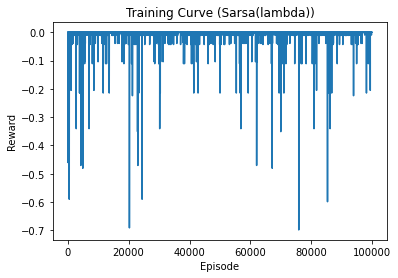

In [145]:
# Evaluation: reward

#Plot the training curve of rewards:
plt.plot(range(1, num_episodes + 1), rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Curve (Sarsa(lambda))")
plt.show()

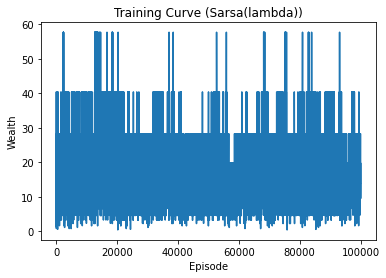

In [146]:
# Evaluation: wealth

#Plot the training curve of wealths:
plt.plot(range(1, num_episodes + 1), wealths)
plt.xlabel("Episode")
plt.ylabel("Wealth")
plt.title("Training Curve (Sarsa(lambda))")
plt.show()

In [147]:
# Print the optimal policy:
policy = model.get_policy()
print("Optimal policy:", policy)

Optimal policy: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0
 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1
 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1
 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1
 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0
 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1
 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0
 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 

In [148]:
# Find the wealth index of the policy that chooses to buy risky asset
policy_arr = np.array(policy)
np.where(policy_arr == 1)

(array([172, 176, 177, 178, 179, 181, 183, 185, 188, 190, 193, 210, 211,
        213, 214, 215, 219, 220, 221, 227, 228, 229, 234, 239, 243, 244,
        245, 246, 247, 249, 251, 253, 254, 255, 256, 258, 259, 261, 262,
        266, 269, 277, 283, 284, 285, 286, 287, 288, 290, 292, 293, 295,
        296, 297, 298, 299, 302, 303, 305, 306, 309, 310, 311, 318, 321,
        324, 327, 328, 330, 333, 335, 337, 339, 341, 342, 343, 345, 347,
        348, 349, 352, 353, 355, 359, 363, 372, 373, 378, 380, 382, 384,
        386, 387, 388, 389, 390, 392, 394, 395, 397, 399, 400, 401, 402,
        403, 404, 406, 407, 411, 412, 415, 429, 430, 431, 435, 436, 437,
        438, 439, 440, 441, 442, 444, 445, 446, 449, 451, 453, 458, 459,
        460, 473, 483, 484, 485, 486, 489, 491, 492, 494, 495, 496, 498,
        521, 523, 525, 528, 530, 531, 532, 533, 534, 537, 541, 561, 564,
        565, 571, 574, 589, 591, 593, 618, 657], dtype=int64),)

Then try a similar method: Sarsa(0)  
Sarsa(0) just consider one-step, and the eligibility trace for all states except the current state is 0.

In [149]:
# Sarsa(0)
# Q(S, A) <- Q(S, A) + learn_rate * (R + decay * Q(S', A') - Q(S, A))
class Sarsa0Agent:
    def __init__(self, env, learn_rate=0.1, decay=0.9, epsilon=0.1):
        """
        Initialize Sarsa(0) Agent

        :param env: environment
        :param learn_rate: learn rate, range: [0, 1]
        :param decay: decay factor, range: [0, 1]
        :param epsilon: ε-greedy, range: [0, 1]
        """
        self.env = env
        self.learn_rate = learn_rate
        self.decay = decay
        self.epsilon = epsilon
        # Initial Q table
        self.q = np.zeros((len(env.state_space), len(env.action_space)))

    def act(self, state):
        """
        Given current state(wealth), use ε-greedy and max q-value to select the optimal action

        :return: the selected action
        """
        if np.random.random() < self.epsilon:  # Actions are selected at random with a probability of ε
            return np.random.choice(self.env.action_space)
        else:  # The action with the largest Q value is the optimal action
            state_index = np.where(state_list == state)[0][0]
            return np.argmax(self.q[state_index])

    def update(self, state, action, reward, next_state, next_action):
        """
        Update Q

        :param state: current wealth
        :param next_state: next wealth
        """
        next_state_index = np.where(state_list == next_state)[0][0]
        state_index = np.where(state_list == state)[0][0]
        td_error = (
            reward
            + self.decay * self.q[next_state_index, next_action]
            - self.q[state_index, action]
        )
        self.q[state_index, action] += self.learn_rate * td_error

    def train(self, num_episodes):
        """
        Train the Sarsa0Agent

        :param num_episodes: the number of episodes
        """
        rewards = [] # record reward of each episode
        wealths = [] # record wealth of each episode
        for i in range(num_episodes):
            wealth = self.env.reset()
            done = False
            while not done:
                action = self.act(wealth)
                next_wealth, reward, done = self.env.step(action)
                next_action = self.act(next_wealth)
                self.update(wealth, action, reward, next_wealth, next_action)
                wealth = next_wealth
            terminal_wealth = wealth
            wealths.append(terminal_wealth)
            rewards.append(reward)
        return wealths, rewards # return the records of wealths and rewards in all episodes

    def get_policy(self):
        """
        Get the optimal policy

        :return the optimal policy
        """
        return np.argmax(self.q, axis=1)

In [150]:
# Train the Sarsa0Agent
env = AssetEnv(p=0.99, a=0.5, b=0.5, rf=0.05)
model = Sarsa0Agent(env)
num_episodes = 100000
wealths, rewards = model.train(num_episodes=num_episodes)

Calculate the mean and standard deviation of all elements in the rewards and wealths array respectively.  
The higher the average reward, the better the model performs in the environment.   
The smaller the standard deviation, the more stable the performance of the model in different episodes.

In [151]:
avg_wealth = np.mean(wealths)
std_wealth = np.std(wealths)
avg_reward = np.mean(rewards)
std_reward = np.std(rewards)
print(f"Average wealth: {avg_wealth:.2f}, std: {std_wealth:.2f}")
print(f"Average reward: {avg_reward:.2f}, std: {std_reward:.2f}")

Average wealth: 19.12, std: 6.68
Average reward: -0.00, std: 0.01


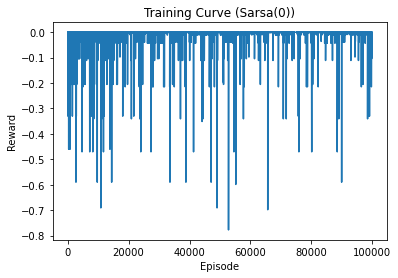

In [152]:
# Evaluation: reward

#Plot the training curve of rewards:
plt.plot(range(1, num_episodes + 1), rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Curve (Sarsa(0))")
plt.show()

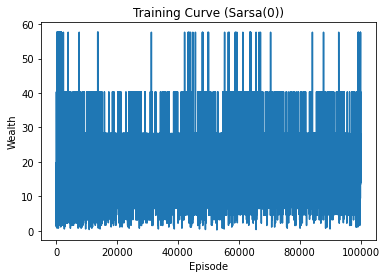

In [153]:
# Evaluation: wealth

#Plot the training curve of wealths:
plt.plot(range(1, num_episodes + 1), wealths)
plt.xlabel("Episode")
plt.ylabel("Wealth")
plt.title("Training Curve (Sarsa(0))")
plt.show()

In [154]:
# Print the optimal policy:
policy = model.get_policy()
print("Optimal policy:", policy)

Optimal policy: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0
 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0
 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1
 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1
 0 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 1 1 1 

In [155]:
# Find the wealth index of the policy that chooses to buy risky asset
policy_arr = np.array(policy)
np.where(policy_arr == 1)

(array([160, 177, 179, 190, 193, 214, 219, 220, 222, 227, 228, 229, 239,
        244, 245, 247, 249, 251, 257, 261, 262, 269, 277, 283, 284, 285,
        286, 287, 288, 289, 296, 298, 299, 302, 303, 304, 306, 310, 311,
        318, 321, 327, 329, 330, 331, 334, 335, 336, 337, 339, 340, 341,
        344, 345, 347, 348, 349, 352, 353, 354, 355, 359, 372, 373, 378,
        381, 382, 383, 384, 385, 386, 387, 388, 390, 391, 392, 393, 394,
        395, 396, 397, 399, 400, 401, 406, 407, 411, 412, 415, 423, 429,
        430, 431, 433, 434, 435, 436, 438, 439, 440, 442, 443, 445, 446,
        447, 448, 449, 451, 453, 457, 458, 459, 460, 473, 481, 482, 483,
        484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 495, 496, 498,
        499, 504, 521, 522, 524, 525, 526, 527, 528, 529, 530, 531, 532,
        533, 560, 561, 562, 563, 565, 566, 589, 615, 657], dtype=int64),)

Several findings:  
When the risky asset return is extreme, i.e. a = b = 0.5 and prob = 0.99, reward traning curve shows that the reward increases with the number of episodes.  
Among three methods, Q-Learning has the smallest average wealth and average std (the most stable), Sarsa(0) has the largest average wealth and average std, while the performance of Sarsa(lambda) is between them.

# Continuous State

In [ ]:
# define the global variables
Max_wealth = 1
ACTION_SPLIT = 100
ACTIONS = np.linspace(0,Max_wealth,ACTION_SPLIT+1) # discretize action from [0,1], does not allow shorting
EPSILON = 0.1                             # epsilon for epsilon greedy algorithm 
decay = 0.95
MIN_EPSILON = 0.01
RISK_FREE = 0.01                          # risk free return for each period
Prob = 0.6                              # Probability that risky asset go up by alpha
ALPHA = 0.1                               
BETA = -0.1
T = 10
RISK_AVERSION = 1                          # Risk aversion parameter in reward function

## Reinforcement Learning's Utility Functions

In [ ]:
# The reward function in Terminal
def Reward_func(wealth,risk_aversion):
    return (-math.exp(-risk_aversion*wealth))/risk_aversion

In [ ]:
# Given current wealth and current action, calculate the next period's wealth and reward
def step(wealth,action):
    if action > 0:
        if np.random.binomial(1, Prob) == 1:
            new_wealth = action*(ALPHA-RISK_FREE)+wealth*(1+RISK_FREE)
        else:
            new_wealth = action*(BETA-RISK_FREE)+wealth*(1+RISK_FREE)
    else:
        new_wealth = wealth * (1+RISK_FREE)
    return new_wealth,0

In [ ]:
# Select the optimal action given current wealth and Q_function by epsilon-greedy algorithm
def get_action(wealth, value_function):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    values = []
    for action in ACTIONS:
        values.append(value_function.value(wealth, action))
    return ACTIONS[np.random.choice([action_ for action_, value_ in enumerate(values) if value_ == np.max(values)])]

In [ ]:
# Semi_gradient_sarsa algorithm for Q_learning
def semi_gradient_sarsa(value_function,random_start = False):
    if random_start == True:
        current_wealth = np.random.uniform(0,Max_wealth)
    else:
        current_wealth = 0.5
    current_action = round(np.random.uniform(0,1),2)
    #current_action = get_action(current_wealth,value_function)

    # track previous wealth, action and reward
    wealths = [current_wealth]
    actions = [current_action]
    rewards = [0.0]

    t = 0
    returns = 0.0
    while(True):
        t = t+1
        # take current action and go to the new state
        if t == T:
            terminal_wealth, _ = step(current_wealth,current_action)
            reward = Reward_func(terminal_wealth,RISK_AVERSION)
            wealths.append(terminal_wealth)
            #learn at terminal
            value_function.learn_terminal(current_wealth, current_action,reward)
            break
        new_wealth, reward = step(current_wealth,current_action)
        # choose new action
        new_action = get_action(new_wealth,value_function)

        # track new state and action
        wealths.append(new_wealth)
        actions.append(new_action)
        rewards.append(reward)
       
        # gradient-learning
        value_function.learn(wealths[t], actions[t],wealths[t-1],actions[t-1],reward)
        current_wealth = new_wealth
        current_action = new_action
    rewards.append(reward)
    return wealths,actions,rewards

In [ ]:
# Training Function
def train_model(episodes,v,EPSILON_temp,random_start = False):
    para_num = len(v.weights)
    weights = []
    w_10 = []
    for ep in tnrange(episodes):
        if ep % 1000 == 0:
            EPSILON_temp *= decay
            EPSILON_temp = max(MIN_EPSILON,EPSILON_temp)
        wealth,_,_= semi_gradient_sarsa(v,random_start)
        weights.append([v.weights[i] for i in range(para_num)])
        w_10.append(wealth[-1])
    return np.array(weights),w_10

In [ ]:
from matplotlib.pyplot import figure
def plot_result(weights,w_10,episodes):
    for i in range(len(weights[0])):
        figure(figsize=(15, 4), dpi=90)
        plt.plot(np.linspace(1,episodes,episodes),weights[:,i])
        plt.xlabel('Number of Episodes')
        plt.ylabel('Weight_%d' %(i))
        plt.show()
    
    figure(figsize=(15, 4), dpi=90)
    plt.plot(np.linspace(1,episodes,episodes),w_10)
    plt.xlabel('Number of Episodes')
    plt.ylabel('final wealth')
    plt.show()

## Action-value function Approximation 

### Linear 

$$Q(w_t,x_t) = q_0 \cdot w_t+q_1 \cdot x_t+q_2$$

In [ ]:
class Action_Value_Function_Linear:
    def __init__(self,para,learn_rate):
        self.weights = np.zeros(para + 1)
        self.learn_rate = learn_rate

    # estimate the value of given state and action
    def value(self, wealth, action):
        return self.weights[0]*wealth+self.weights[1]*action+self.weights[2]

    # learn with given state, action and target
    def learn(self, wealth_new, action_new,wealth_old,action_old,reward):
        delta = self.learn_rate * (reward+self.value(wealth_new,action_new)-self.value(wealth_old,action_old))
        self.weights[0] += delta*wealth_old
        self.weights[1] += delta*action_old
        self.weights[2] += delta*1
    
    #learn at terminal, which will be used in semi-gradient SARSA
    def learn_terminal(self, wealth, action,reward):
        delta = self.learn_rate * (reward-self.value(wealth,action))
        self.weights[0] += delta*wealth
        self.weights[1] += delta*action
        self.weights[2] += delta*1

  0%|          | 0/10000 [00:00<?, ?it/s]

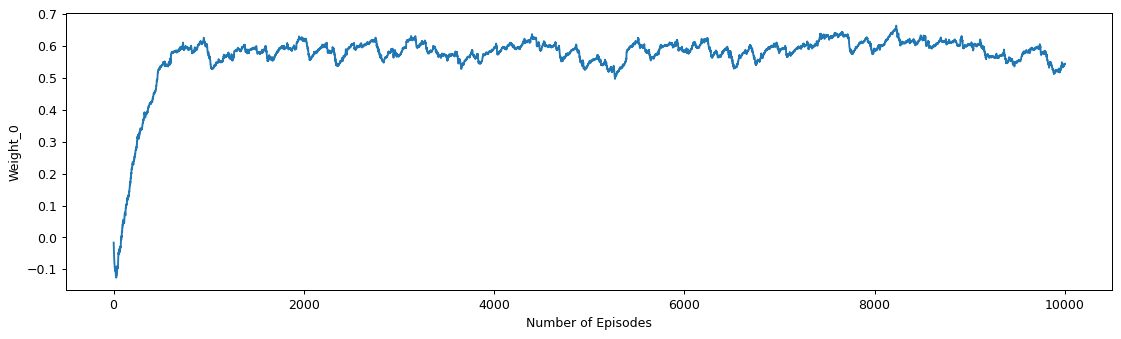

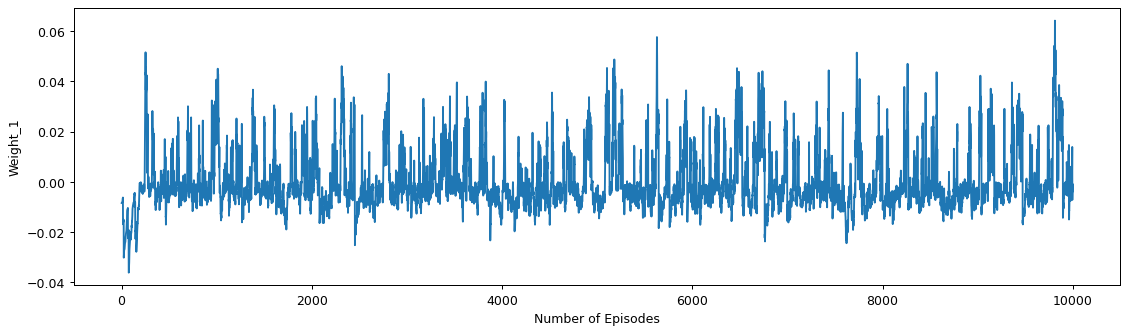

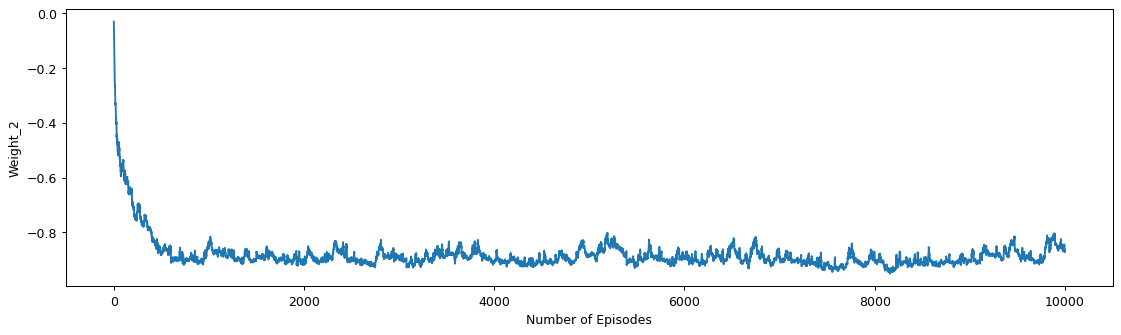

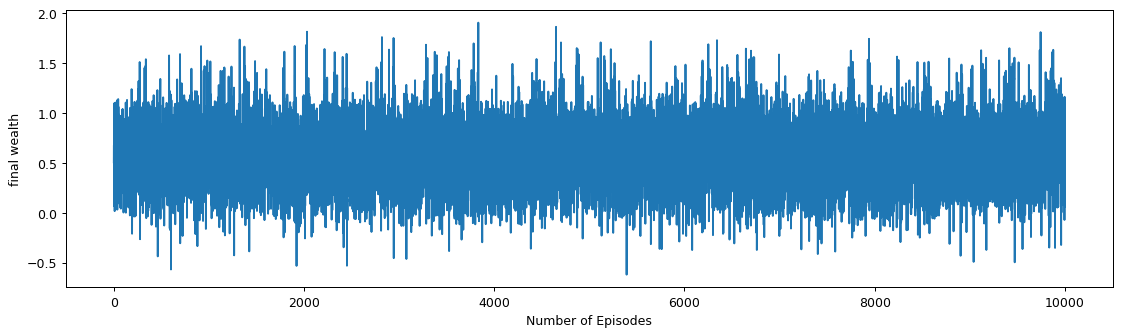

In [ ]:
episodes = 10000
value_function = Action_Value_Function_Linear(2, 0.05)
weights,w_10=train_model(episodes,value_function,EPSILON,True)
plot_result(weights,w_10,episodes)

### Polynomial with Order 2

$$Q(w_t,x_t) = q_0 \cdot w_t+q_1 \cdot w_t^2+q_2 \cdot x_t+ q_3 \cdot x_t^2+q_4$$

In [ ]:
class Action_Value_Function_Polynomial:
    def __init__(self,order,learn_rate):
        self.weights = np.zeros(order*2+1)
        self.learn_rate = learn_rate

    # estimate the value of given state and action
    def value(self, wealth, action):
        return self.weights[0]*wealth+self.weights[1]*wealth**2+self.weights[2]*action+self.weights[3]*action**2+self.weights[4]

    # learn with given state, action and target
    def learn(self, wealth_new, action_new,wealth_old,action_old,reward):
        delta = self.learn_rate * (reward+self.value(wealth_new,action_new)-self.value(wealth_old,action_old))
        self.weights[0] += delta*wealth_old
        self.weights[1] += delta*wealth_old**2
        self.weights[2] += delta*action_old
        self.weights[3] += delta*action_old**2
        self.weights[4] += delta*1
    
    #learn at terminal, which will be used in semi-gradient SARSA
    def learn_terminal(self, wealth, action,reward):
        delta = self.learn_rate * (reward-self.value(wealth,action))
        self.weights[0] += delta*wealth
        self.weights[1] += delta*wealth**2
        self.weights[2] += delta*action
        self.weights[3] += delta*action**2
        self.weights[4] += delta*1

  0%|          | 0/10000 [00:00<?, ?it/s]

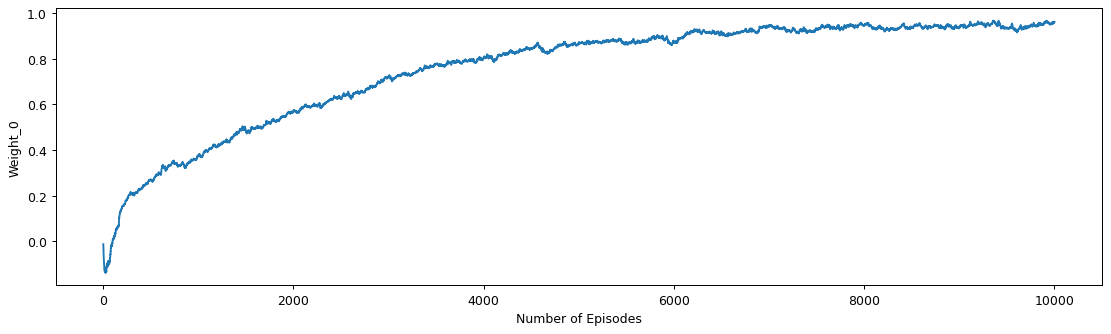

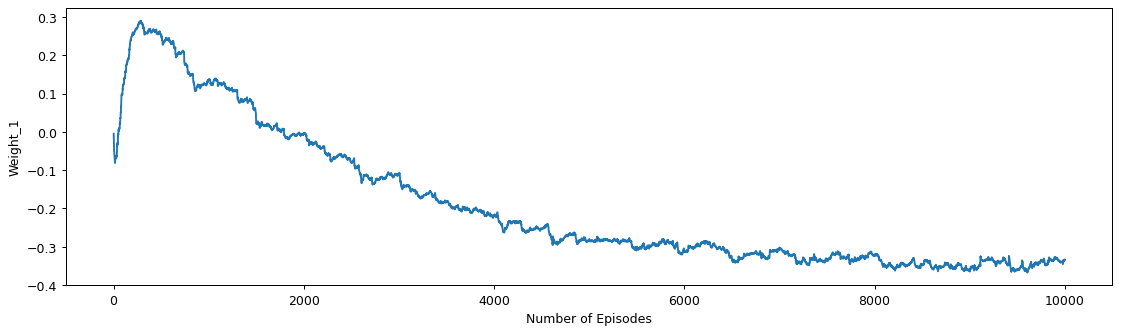

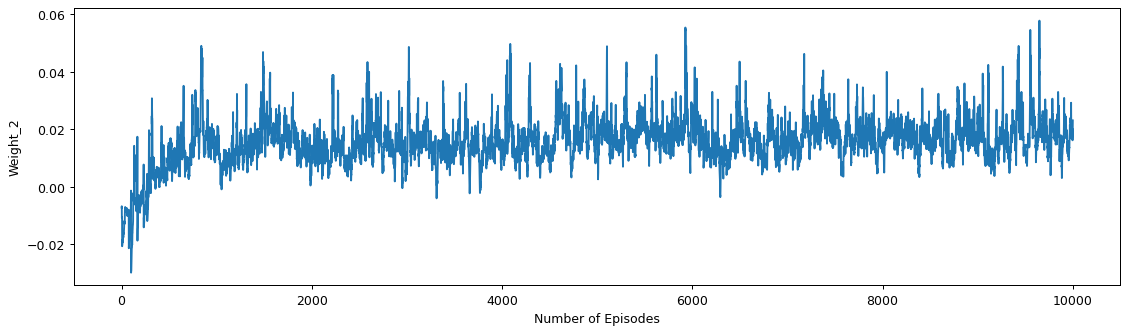

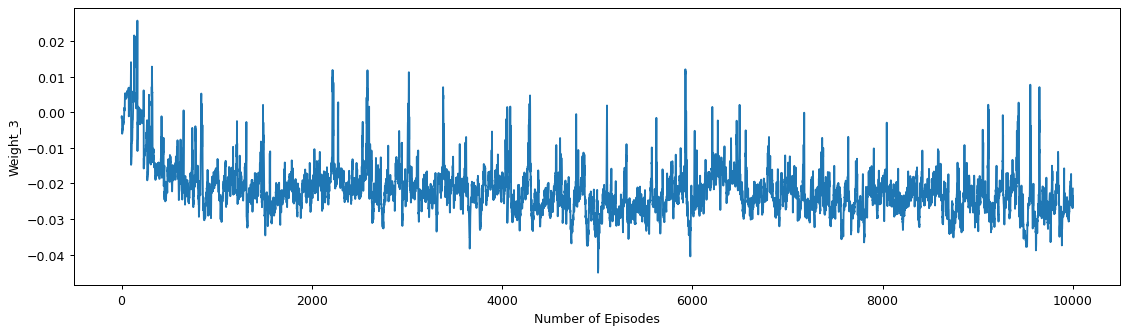

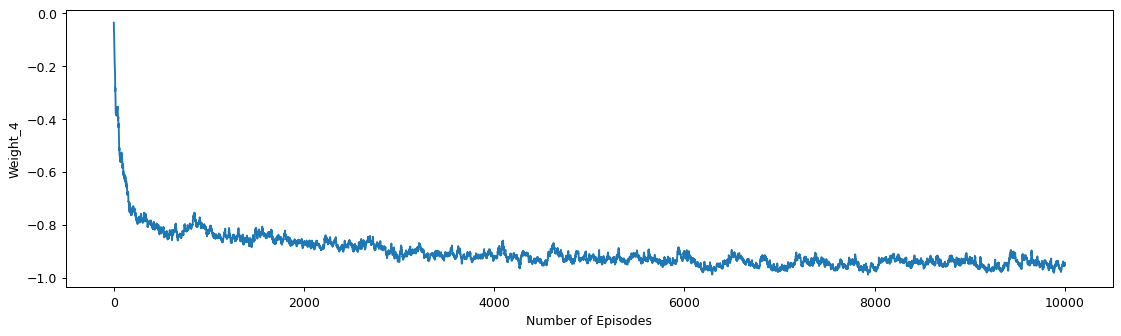

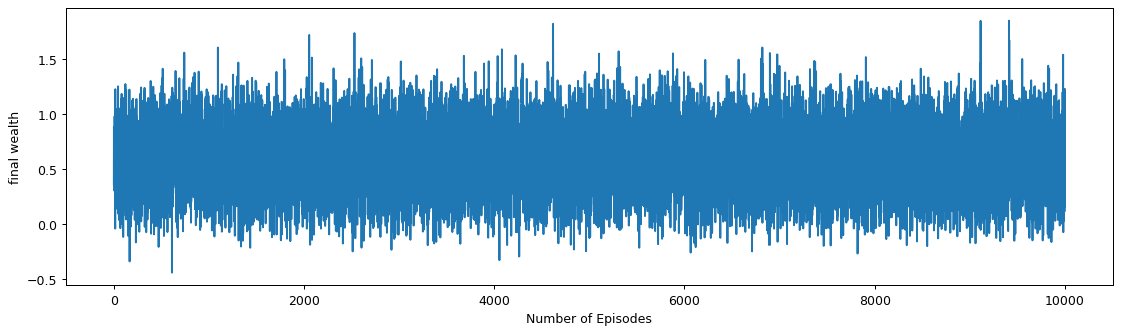

In [ ]:
episodes = 10000
value_function = Action_Value_Function_Polynomial(2, 0.05)
weights,w_10=train_model(episodes,value_function,EPSILON,True)
plot_result(weights,w_10,episodes)

### Exponential Model

$$Q(w_t,x_t) = e^{q_0 \cdot w_t+q_1 \cdot x_t+q_2}$$

In [ ]:
class Action_Value_Function_exponential:
    def __init__(self,para,learn_rate):
        self.weights = np.zeros(para + 1)
        self.learn_rate = learn_rate

    # estimate the value of given state and action
    def value(self, wealth, action):
        return np.exp(-self.weights[0]*wealth-self.weights[1]*action-self.weights[2])

    # learn with given state, action and target
    def learn(self, wealth_new, action_new,wealth_old,action_old,reward):
        weights = self.weights
        delta = self.learn_rate * (reward+self.value(wealth_new,action_new)-self.value(wealth_old,action_old))
        self.weights[0] -= delta*wealth_old*np.exp(-weights[0]*wealth_old-weights[1]*action_old-weights[2])
        self.weights[1] -= delta*action_old*np.exp(-weights[0]*wealth_old-weights[1]*action_old-weights[2])
        self.weights[2] -= delta*np.exp(-weights[0]*wealth_old-weights[1]*action_old-weights[2])
    
    #learn at terminal, which will be used in semi-gradient SARSA
    def learn_terminal(self, wealth, action,reward):
        weights = self.weights
        delta = self.learn_rate * (reward-self.value(wealth,action))
        self.weights[0] -= delta*wealth*np.exp(-weights[0]*wealth-weights[1]*action-weights[2])
        self.weights[1] -= delta*action*np.exp(-weights[0]*wealth-weights[1]*action-weights[2])
        self.weights[2] -= delta*np.exp(-weights[0]*wealth-weights[1]*action-weights[2])
 

  0%|          | 0/10000 [00:00<?, ?it/s]

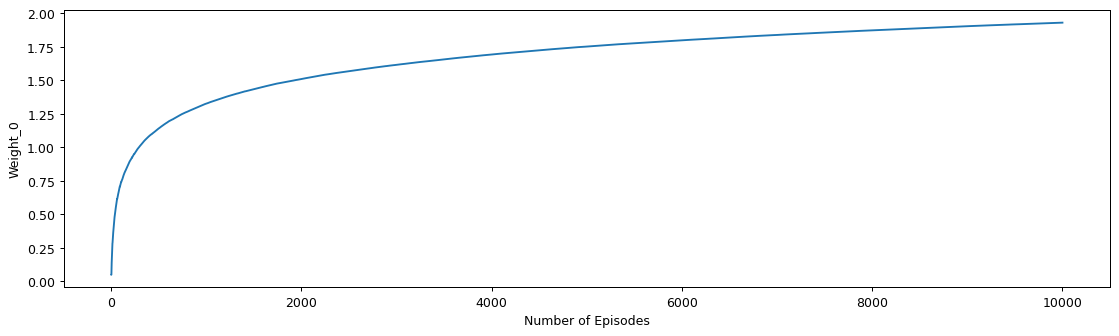

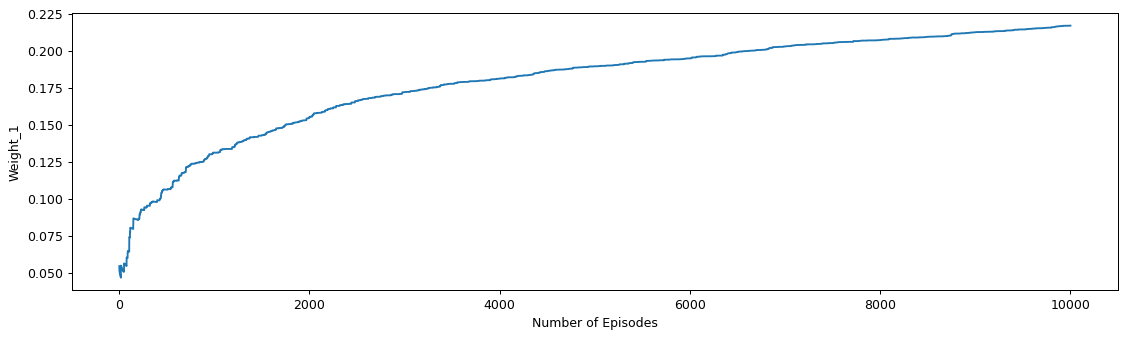

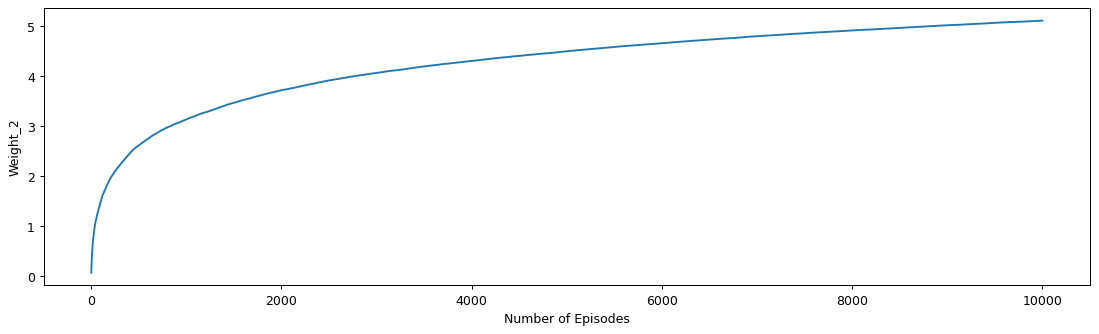

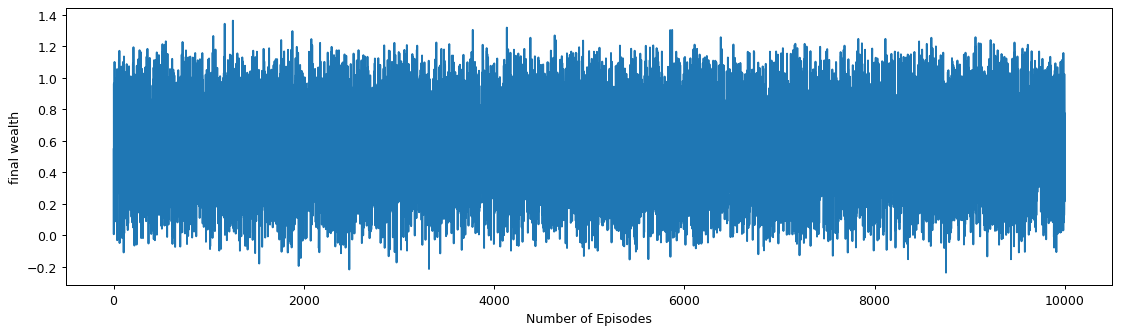

In [ ]:
episodes = 10000
value_function = Action_Value_Function_exponential(2, 0.05)
weights,w_10=train_model(episodes,value_function,EPSILON,True)
plot_result(weights,w_10,episodes)

### Based on analytical solution

$$Q_t(w_t,x_t) = -b_{t+1}e^{c_{t+1} \cdot [x_t(r-b)-w_t(1+r)]} \cdot [1-p+p \cdot e^{c_{t+1} \cdot x_t(a-b)}]$$

In [ ]:
class Action_Value_Function_analysis:
    def __init__(self,para,learn_rate):
        self.weights = np.zeros(para)
        self.learn_rate = learn_rate

    # estimate the value of given state and action
    def value(self, wealth, action):
        return (1-Prob)*(-self.weights[0])*math.exp(self.weights[1]*action*(RISK_FREE-BETA)-self.weights[1]*wealth*(1+RISK_FREE))\
            + Prob*(-self.weights[0])*math.exp(self.weights[1]*action*(RISK_FREE-ALPHA)-self.weights[1]*wealth*(1+RISK_FREE))

    # learn with given state, action and target
    def learn(self, wealth_new, action_new,wealth_old,action_old,reward):
        weights = self.weights
        delta = self.learn_rate * (reward+self.value(wealth_new,action_new)-self.value(wealth_old,action_old))
        self.weights[0] -= delta*((1-Prob)*math.exp(weights[1]*action_old*(RISK_FREE-BETA)-weights[1]*wealth_old*(1+RISK_FREE))\
                                 +Prob*math.exp(weights[1]*action_old*(RISK_FREE-ALPHA)-weights[1]*wealth_old*(1+RISK_FREE)))
                                  
        self.weights[1] -= delta*((1-Prob)*(weights[0])*math.exp(weights[1]*action_old*(RISK_FREE-BETA)-weights[1]*wealth_old*(1+RISK_FREE))\
                                  *(action_old*(RISK_FREE-BETA)-wealth_old*(1+RISK_FREE))+\
                                 Prob*(weights[0])*math.exp(weights[1]*action_old*(RISK_FREE-ALPHA)-weights[1]*wealth_old*(1+RISK_FREE))\
                                    *(action_old*(RISK_FREE-ALPHA)-wealth_old*(1+RISK_FREE)))
    
    #learn at terminal, which will be used in semi-gradient SARSA    
    def learn_terminal(self, wealth, action,reward):
        weights = self.weights
        delta = self.learn_rate * (reward-self.value(wealth,action))
        self.weights[0] -= delta*((1-Prob)*math.exp(weights[1]*action*(RISK_FREE-BETA)-weights[1]*wealth*(1+RISK_FREE))\
                                 +Prob*math.exp(weights[1]*action*(RISK_FREE-ALPHA)-weights[1]*wealth*(1+RISK_FREE)))
                                  
        self.weights[1] -= delta*((1-Prob)*(weights[0])*math.exp(weights[1]*action*(RISK_FREE-BETA)-weights[1]*wealth*(1+RISK_FREE))\
                                  *(action*(RISK_FREE-BETA)-wealth*(1+RISK_FREE))+\
                                 Prob*(weights[0])*math.exp(weights[1]*action*(RISK_FREE-ALPHA)-weights[1]*wealth*(1+RISK_FREE))\
                                    *(action*(RISK_FREE-ALPHA)-wealth*(1+RISK_FREE)))

  0%|          | 0/10000 [00:00<?, ?it/s]

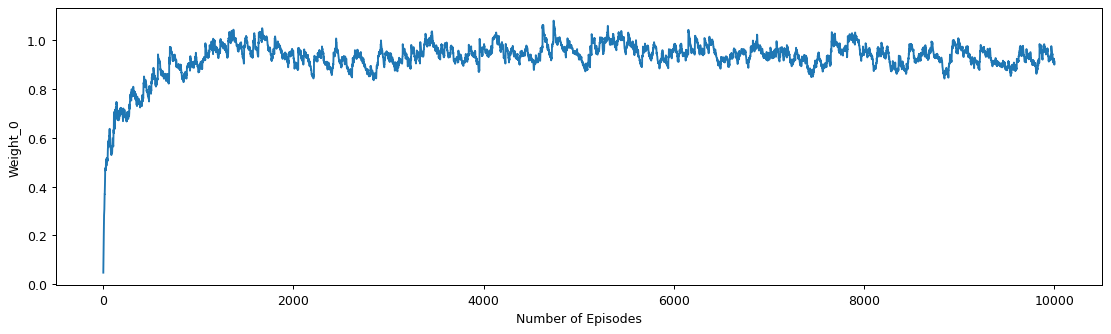

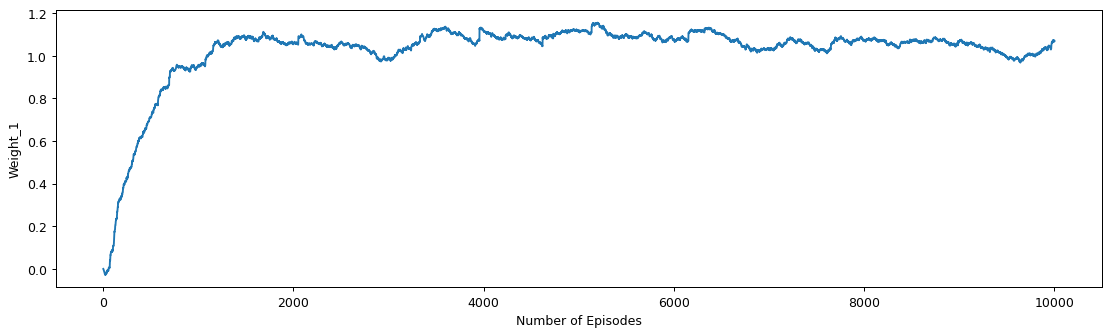

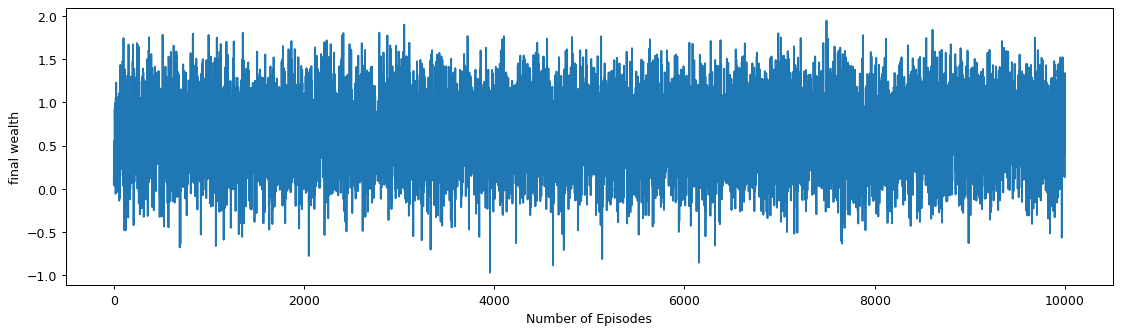

In [ ]:
episodes = 10000
value_function = Action_Value_Function_analysis(2, 0.05)
weights,w_10=train_model(episodes,value_function,EPSILON,True)
plot_result(weights,w_10,episodes)

## Testing robustness

### Test with T=1

Since we have known the analytical solution of value function, we could conduct analysis with shorter period , like T = 1, to check that whether Q function approxiamtion with continous wealth and discretized action could be converged to the analytical solution via semi-gradient SARSA.

In [ ]:
# The new version of analytical Action-Value function is designed for changing the input of GLOBAL VARIABLES, such as ALPHA,BETA ....
class Action_Value_Function_analysis_new:
    def __init__(self,para,learn_rate,alpha,beta,risk_free,prob):
        self.weights = np.zeros(para)
        self.learn_rate = learn_rate
        self.ALPHA = alpha
        self.BETA = beta
        self.risk_free = risk_free
        self.Prob = prob
        
    # estimate the value of given state and action
    def value(self, wealth, action):
        ALPHA = self.ALPHA
        BETA = self.BETA
        RISK_FREE = self.risk_free
        Prob = self.Prob
        return (-self.weights[0])*math.exp(-self.weights[1]*wealth*(1+RISK_FREE))*(Prob*math.exp(-self.weights[1]*action*(ALPHA-RISK_FREE))\
                                                                                    +(1-Prob)*math.exp(-self.weights[1]*action*(BETA-RISK_FREE)))

    # learn with given state, action and target
    def learn(self, wealth_new, action_new,wealth_old,action_old,reward):
        ALPHA = self.ALPHA
        BETA = self.BETA
        RISK_FREE = self.risk_free
        Prob = self.Prob
        weights = self.weights
        delta = self.learn_rate * (reward+self.value(wealth_new,action_new)-self.value(wealth_old,action_old))
        self.weights[0] -= delta*math.exp(-weights[1]*wealth_old*(1+RISK_FREE))*(Prob*math.exp(-weights[1]*action_old*(ALPHA-RISK_FREE))\
                                                                                    +(1-Prob)*math.exp(-weights[1]*action_old*(BETA-RISK_FREE)))
                                  
        self.weights[1] -= delta*weights[0]*(math.exp(-weights[1]*wealth_old*(1+RISK_FREE))*(-wealth_old*(1+RISK_FREE))\
                        *(Prob*math.exp(-weights[1]*action_old*(ALPHA-RISK_FREE))+(1-Prob)*math.exp(-weights[1]*action_old*(BETA-RISK_FREE)))\
                        +math.exp(-weights[1]*wealth_old*(1+RISK_FREE))\
                        *(Prob*math.exp(-weights[1]*action_old*(ALPHA-RISK_FREE))*(-action_old*(ALPHA-RISK_FREE))\
                          +(1-Prob)*math.exp(-weights[1]*action_old*(BETA-RISK_FREE))*(-action_old*(BETA-RISK_FREE))))
    
    def learn_terminal(self, wealth, action,reward):
        ALPHA = self.ALPHA
        BETA = self.BETA
        RISK_FREE = self.risk_free
        Prob = self.Prob
        weights = self.weights
        delta = self.learn_rate * (reward-self.value(wealth,action))
        self.weights[0] -= delta*math.exp(-weights[1]*wealth*(1+RISK_FREE))*(Prob*math.exp(-weights[1]*action*(ALPHA-RISK_FREE))\
                                                                                    +(1-Prob)*math.exp(-weights[1]*action*(BETA-RISK_FREE)))
                                  
        self.weights[1] -= delta*weights[0]*(math.exp(-weights[1]*wealth*(1+RISK_FREE))*(-wealth*(1+RISK_FREE))\
                        *(Prob*math.exp(-weights[1]*action*(ALPHA-RISK_FREE))+(1-Prob)*math.exp(-weights[1]*action*(BETA-RISK_FREE)))\
                        +math.exp(-weights[1]*wealth*(1+RISK_FREE))\
                        *(Prob*math.exp(-weights[1]*action*(ALPHA-RISK_FREE))*(-action*(ALPHA-RISK_FREE))\
                          +(1-Prob)*math.exp(-weights[1]*action*(BETA-RISK_FREE))*(-action*(BETA-RISK_FREE))))

In [ ]:
def semi_gradient_sarsa_test(value_function,T_x,wealth,random_start = False):
    if random_start == True:
        current_wealth = np.random.uniform(0,wealth)
    else:
        current_wealth = 1
    current_action = get_action(current_wealth,value_function)
    # track previous wealth, action and reward
    wealths = [current_wealth]
    actions = [current_action]
    rewards = [0.0]

    t = 0
    returns = 0.0
    while(True):
        t = t+1
        # take current action and go to the new state
        if t == T_x:
            terminal_wealth, _ = step(current_wealth,current_action)
            reward = Reward_func(terminal_wealth,RISK_AVERSION)
            wealths.append(terminal_wealth)
            value_function.learn_terminal(current_wealth, current_action,reward)
            break
        new_wealth, reward = step(current_wealth,current_action)
        # choose new action
        new_action = get_action(new_wealth,value_function)

        # track new state and action
        wealths.append(new_wealth)
        actions.append(new_action)
        rewards.append(reward)
        
        #gradient-learning
        value_function.learn(wealths[t], actions[t],wealths[t-1],actions[t-1],reward)
        current_wealth = new_wealth
        current_action = new_action
    rewards.append(reward)
    return wealths,actions,rewards

In [ ]:
def train_model_test(episodes,v,EPSILON_temp,T_x,Max_wealth,random_start = False):
    para_num = len(v.weights)
    weights = []
    w_10 = []
    actions = []
    for ep in tnrange(episodes):
        if ep % 1000 == 0:
            EPSILON_temp *= decay
            EPSILON_temp = max(MIN_EPSILON,EPSILON_temp)
        wealth,action,_= semi_gradient_sarsa_test(v,T_x,Max_wealth,random_start)
        weights.append([v.weights[i] for i in range(para_num)])
        w_10.append(wealth[-1])
        actions.append(action[-1])
    return np.array(weights),w_10,actions

In [ ]:
episodes = 10000
value_function = Action_Value_Function_analysis_new(2, 0.05,ALPHA,BETA,RISK_FREE,Prob)
weights,w_10,actions=train_model_test(episodes,value_function,EPSILON,T_x = 1,Max_wealth = 1,random_start = True)

  0%|          | 0/10000 [00:00<?, ?it/s]

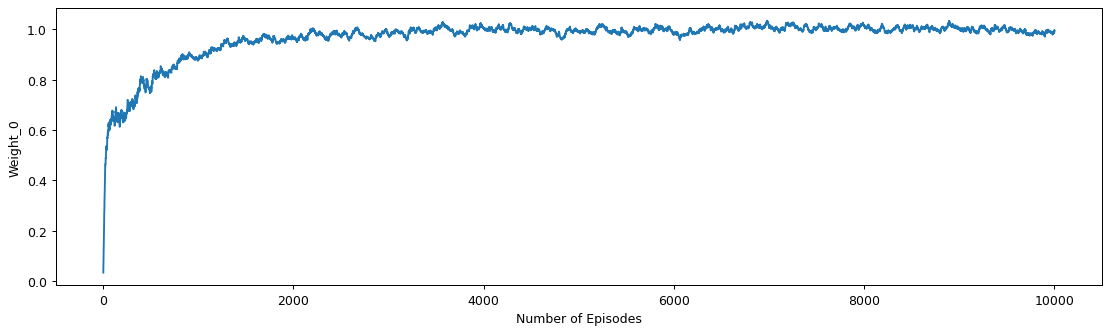

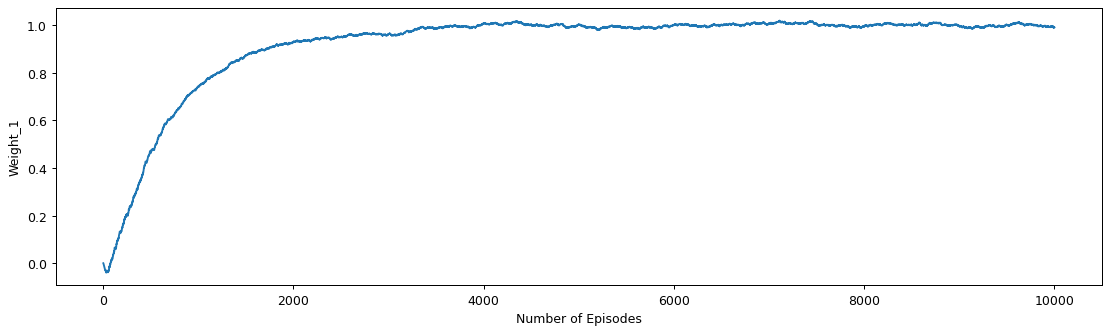

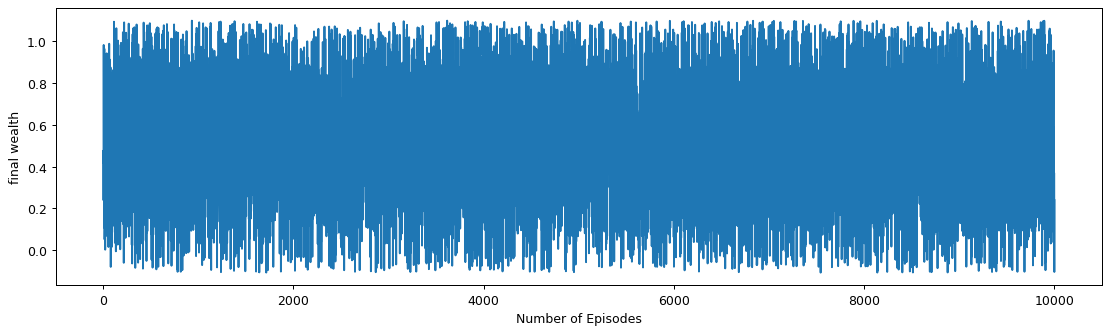

In [ ]:
plot_result(weights,w_10,episodes)

In [ ]:
weights

array([[ 3.29509544e-02, -4.31051881e-04],
       [ 6.23547148e-02, -1.30481748e-03],
       [ 9.86246920e-02, -2.15914486e-03],
       ...,
       [ 9.91089152e-01,  9.90644571e-01],
       [ 9.97507189e-01,  9.90612556e-01],
       [ 9.94557166e-01,  9.91052045e-01]])

In [ ]:
#True Value of weight[0]
(((1-Prob)/Prob * (RISK_FREE - BETA)/(ALPHA - RISK_FREE))**((ALPHA - RISK_FREE)/(ALPHA - BETA)) * Prob +((1-Prob)/Prob * \
            (RISK_FREE - BETA)/(ALPHA - RISK_FREE))**((BETA - RISK_FREE)/(ALPHA - BETA)) * (1-Prob))/RISK_AVERSION

0.9948671098319157

In [ ]:
#True Value of weight[1]
(1+RISK_FREE)*RISK_AVERSION

1.01

### Changing the global parameters

In [ ]:
# change global paramets
Prob = 0.99                             # Probability that risky asset go up by alpha
ALPHA = 0.5                               
BETA = -0.1

In [ ]:
episodes = 10000
value_function = Action_Value_Function_analysis_new(2, 0.05,ALPHA,BETA,RISK_FREE,Prob)
weights,w_10,actions=train_model_test(episodes,value_function,EPSILON,1,Max_wealth = 1,random_start =True)

  0%|          | 0/10000 [00:00<?, ?it/s]

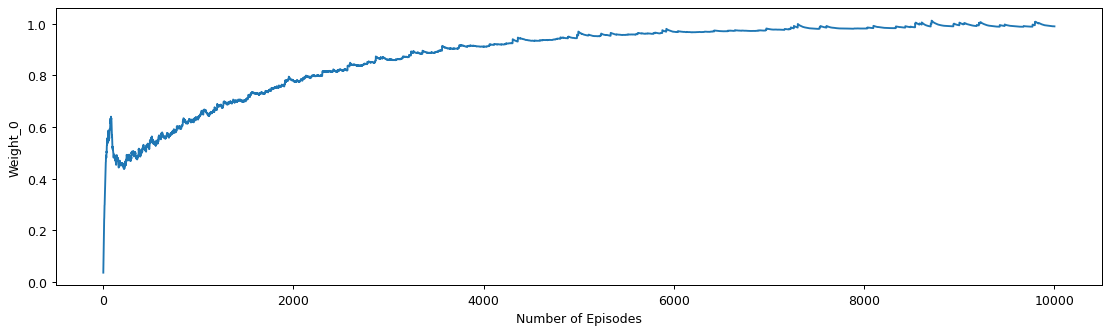

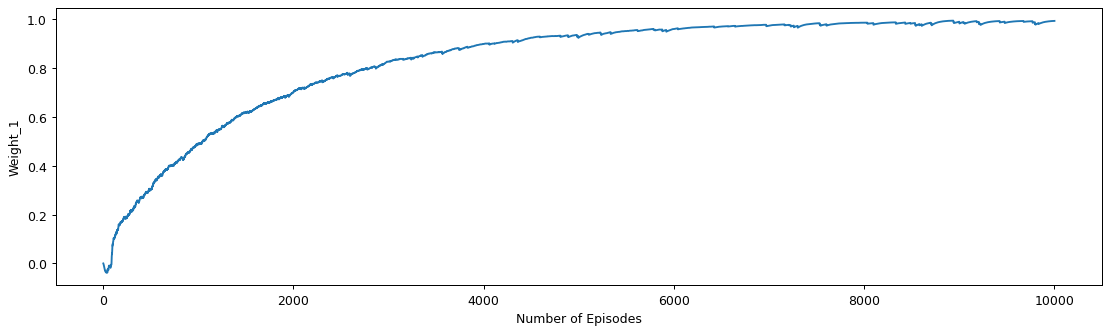

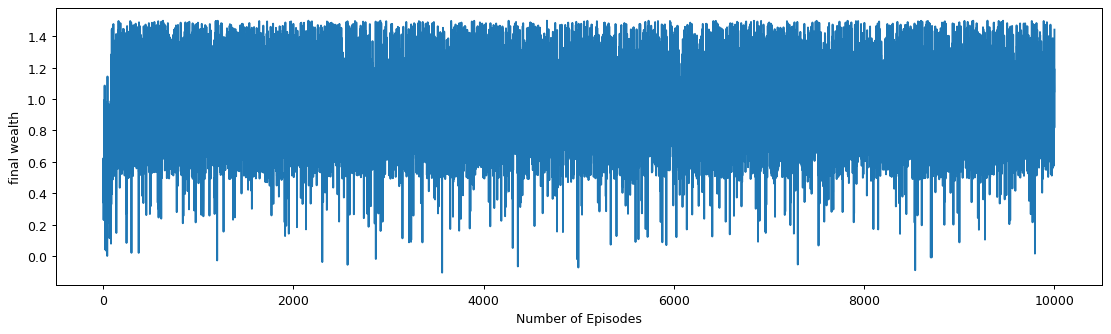

In [ ]:
plot_result(weights,w_10,episodes)

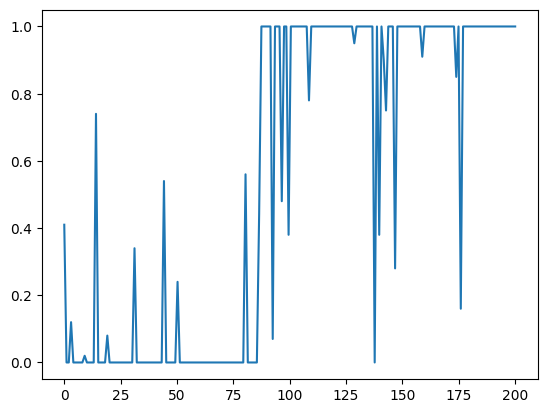

In [ ]:
plt.plot(np.linspace(0,200,200),actions[0:200]) # the action converge to 1 at in 200 episodes

In [ ]:
#True Value of weight[0]
(((1-Prob)/Prob * (RISK_FREE - BETA)/(ALPHA - RISK_FREE))**((ALPHA - RISK_FREE)/(ALPHA - BETA)) * Prob +((1-Prob)/Prob * \
            (RISK_FREE - BETA)/(ALPHA - RISK_FREE))**((BETA - RISK_FREE)/(ALPHA - BETA)) * (1-Prob))/RISK_AVERSION

0.037391157685173426

In [ ]:
#True Value of weight[1]
(1+RISK_FREE)*RISK_AVERSION

1.01

  0%|          | 0/100000 [00:00<?, ?it/s]

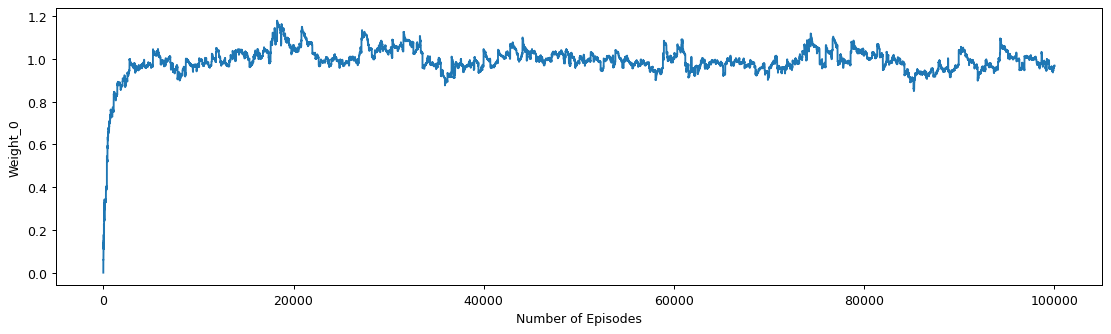

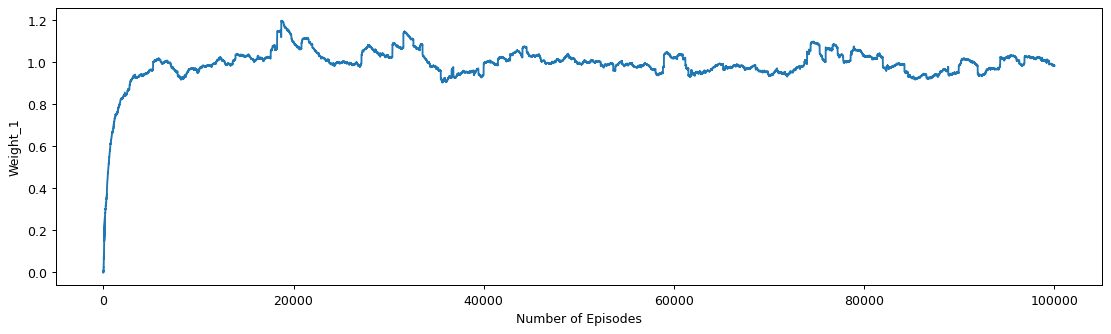

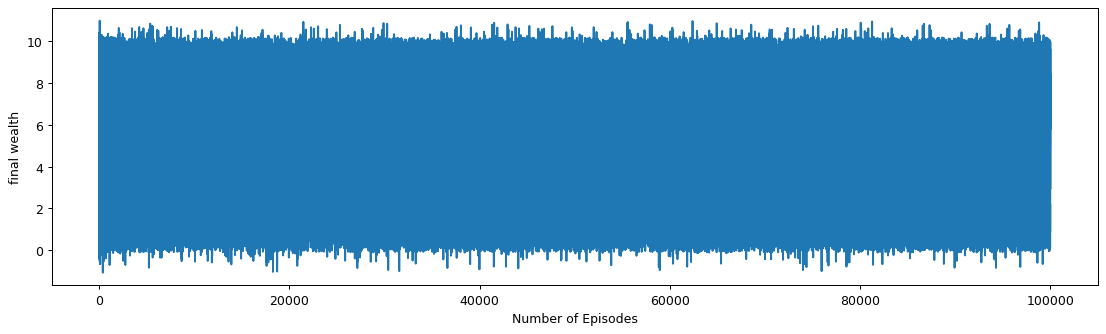

In [ ]:
episodes = 100000
Max_wealth = 10
ACTIONS = np.linspace(0,Max_wealth,ACTION_SPLIT+1)
Prob = 0.6                             # return to normal global variable set
ALPHA = 0.1                               
BETA = -0.1

value_function = Action_Value_Function_analysis_new(2, 0.05,ALPHA,BETA,RISK_FREE,Prob)
weights,w_10,actions=train_model_test(episodes,value_function,EPSILON,1,Max_wealth = Max_wealth,random_start =True)
plot_result(weights,w_10,episodes)

  0%|          | 0/100000 [00:00<?, ?it/s]

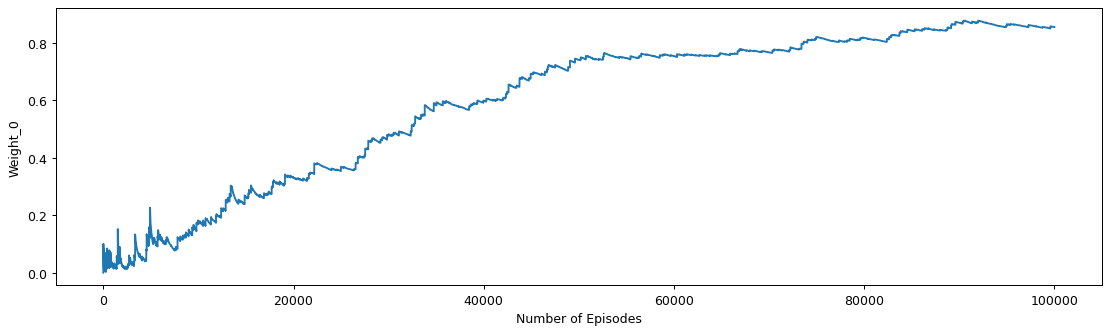

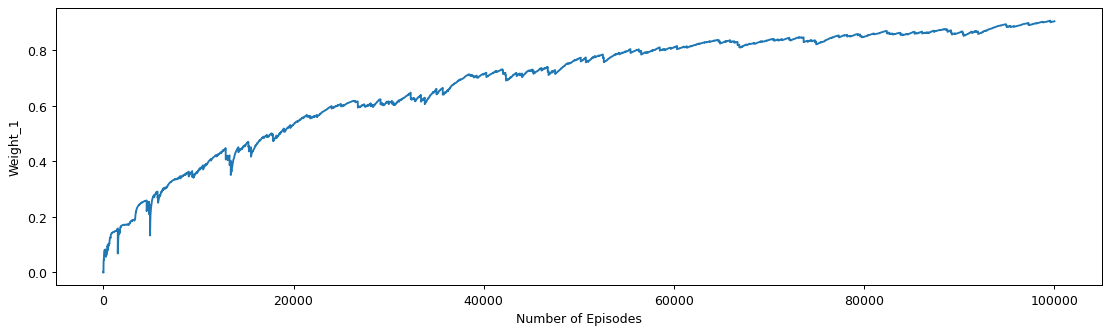

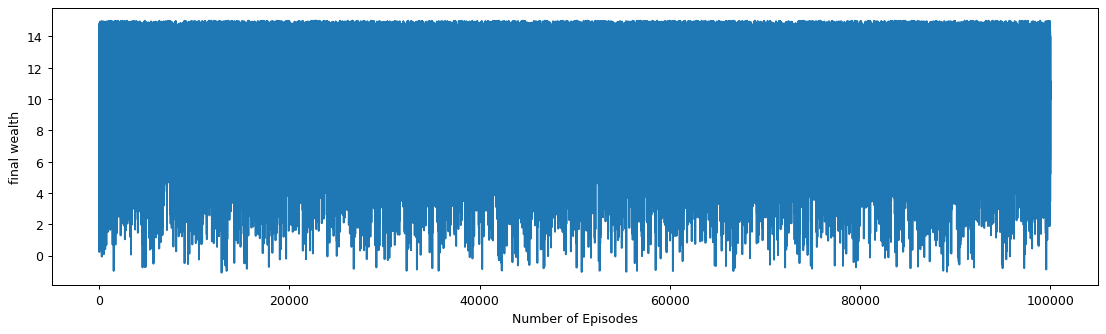

In [ ]:
episodes = 100000
Max_wealth = 10
ACTIONS = np.linspace(0,Max_wealth,ACTION_SPLIT+1)
Prob = 0.99                             # Probability that risky asset go up by alpha
ALPHA = 0.5                               
BETA = -0.1
# it might have math error since the randomness, could reduce the learn rate, i.e. 0.1->0.05
value_function = Action_Value_Function_analysis_new(2, 0.1,ALPHA,BETA,RISK_FREE,Prob)  
weights,w_10,actions=train_model_test(episodes,value_function,EPSILON,1,Max_wealth = Max_wealth,random_start =True)
plot_result(weights,w_10,episodes)

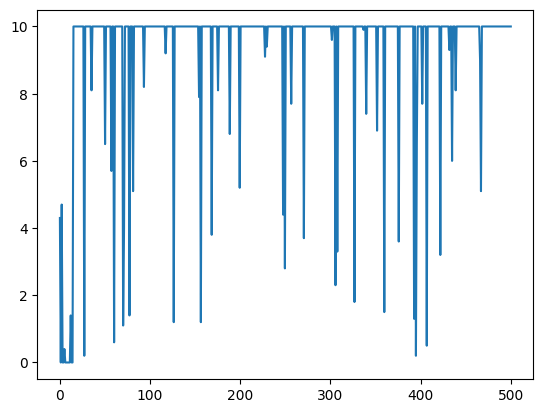

In [ ]:
plt.plot(np.linspace(0,500,500),actions[0:500]) # the action converge to 1 at in 500 episodes

From the above research, we discover several findings: 
1. The approximated Action-value function converges to the analytical solution given the original global parameter set, and it is robust in terms of maximum wealth. However, due to the expoential part in the gradient, the maximum wealth could not set too high as it will occur math range error due to the randomness of intial wealth.

2. The approximation does not converge to true value when the risky asset return is extreme, i.e. alpha = 0.5 and prob = 0.99. However, after plotting the action,we discover that the action quickly go to the maximum wealth, which caters to the situation. The fluctuation of action exists due to the $\epsilon$ -greedy algo.

 ### Multiple Q models

In [ ]:
Max_wealth = 1
ACTION_SPLIT = 100
ACTIONS = np.linspace(0,Max_wealth,ACTION_SPLIT+1) # discretize action from [0,1], does not allow shorting
EPSILON = 0.1                             # epsilon for epsilon greedy algorithm 
decay = 0.95
MIN_EPSILON = 0.01
RISK_FREE = 0.01                          # risk free return for each period
Prob = 0.6                              # Probability that risky asset go up by alpha
ALPHA = 0.1                               
BETA = -0.1
T = 10
RISK_AVERSION = 1         

From the analytical solution, we know that Q_function depends on T, that is each Q_t(w_t,x_t) correspond to different b_t and c_t. Thus, we try on training multiple Q_functions simutanously to discover whether such model is useful.

In [ ]:
class Action_Value_Function_value:
    def __init__(self,para,learn_rate):
        self.weights = np.zeros(para)
        self.learn_rate = learn_rate

    # estimate the value of given state and action
    def value(self, wealth, action):
        return (-self.weights[0])*math.exp(-self.weights[1]*wealth*(1+RISK_FREE))*(Prob*math.exp(-self.weights[1]*action*(ALPHA-RISK_FREE))\
                                                                                    +(1-Prob)*math.exp(-self.weights[1]*action*(BETA-RISK_FREE)))


In [ ]:
def gradient(weights,wealth,action):
    return np.array([math.exp(-weights[1]*wealth*(1+RISK_FREE))*(Prob*math.exp(-weights[1]*action*(ALPHA-RISK_FREE))\
                                                                                    +(1-Prob)*math.exp(-weights[1]*action*(BETA-RISK_FREE))),
            weights[0]*(math.exp(-weights[1]*wealth*(1+RISK_FREE))*(-wealth*(1+RISK_FREE))\
                        *(Prob*math.exp(-weights[1]*action*(ALPHA-RISK_FREE))+(1-Prob)*math.exp(-weights[1]*action*(BETA-RISK_FREE)))\
                        +math.exp(-weights[1]*wealth*(1+RISK_FREE))\
                        *(Prob*math.exp(-weights[1]*action*(ALPHA-RISK_FREE))*(-action*(ALPHA-RISK_FREE))\
                          +(1-Prob)*math.exp(-weights[1]*action*(BETA-RISK_FREE))*(-action*(BETA-RISK_FREE))))])

In [ ]:
def semi_gradient_sarsa_multi_Q(value_function,T_x,wealth,random_start = False):
    if random_start == True:
        current_wealth = np.random.uniform(0,wealth)
    else:
        current_wealth = 1
    #current_action = round(np.random.uniform(0,1),2)
    current_action = get_action(current_wealth,value_function[0])

    # track previous position, velocity, action and reward
    wealths = [current_wealth]
    actions = [current_action]
    rewards = [0.0]

    t = 0
    returns = 0.0
    while(True):
        t = t+1
        # take current action and go to the new state
        if t == T_x:
            terminal_wealth, _ = step(current_wealth,current_action)
            reward = Reward_func(terminal_wealth,RISK_AVERSION)
            wealths.append(terminal_wealth)
            delta = value_function[t-1].learn_rate*(reward-value_function[t-1].value(current_wealth,current_action))
            value_function[t-1].weights -= delta*gradient(value_function[t-1].weights,current_wealth,current_action)
            break
        new_wealth, reward = step(current_wealth,current_action)
        # choose new action
        new_action = get_action(new_wealth,value_function[t-1])

        # track new state and action
        wealths.append(new_wealth)
        actions.append(new_action)
        rewards.append(reward)
        # get the time of the state to update
       
        delta = value_function[t-1].learn_rate*(reward+value_function[t].value(new_wealth,new_action)-value_function[t-1].value(current_wealth,current_action))
        value_function[t-1].weights -= delta*gradient(value_function[t-1].weights,current_wealth,current_action)
        current_wealth = new_wealth
        current_action = new_action
    rewards.append(reward)
    return wealths,actions,rewards

In [ ]:
def train_model_multi_Q(episodes,v,EPSILON_temp,T_x,max_wealth,random_start = False):
    para_num = len(v[0].weights)
    weights_0 = []
    weights_1 = []
    w_10 = []
    for ep in tnrange(episodes):
        if ep % 1000 == 0:
            EPSILON_temp *= decay
            EPSILON_temp = max(MIN_EPSILON,EPSILON_temp)
        wealth,_,_= semi_gradient_sarsa_multi_Q(v,T_x,max_wealth,random_start)
        weights_0.append([v[i].weights[0] for i in range(T_x)])
        weights_1.append([v[i].weights[1] for i in range(T_x)])
        w_10.append([wealth[-1]])
    return np.array(weights_0),np.array(weights_1),w_10

In [ ]:
episodes = 100000
value_function = []
value_function.append(Action_Value_Function_value(2, 0.01))
value_function.append(Action_Value_Function_value(2, 0.01))
weights_0,weights_1,w_10=train_model_multi_Q(episodes,value_function,EPSILON,T_x=2,max_wealth = 1,random_start=True)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
value_function[0].weights

array([1.00357652, 1.01100275])

In [ ]:
#True value:
[(((1-Prob)/Prob * (RISK_FREE - BETA)/(ALPHA - RISK_FREE))**((ALPHA - RISK_FREE)/(ALPHA - BETA)) * Prob +((1-Prob)/Prob * \
            (RISK_FREE - BETA)/(ALPHA - RISK_FREE))**((BETA - RISK_FREE)/(ALPHA - BETA)) * (1-Prob))**2/RISK_AVERSION,
 
(1+RISK_FREE)**2*RISK_AVERSION]

[0.9897605662253091, 1.0201]

In [ ]:
value_function[1].weights

array([1.00061523, 1.02009738])

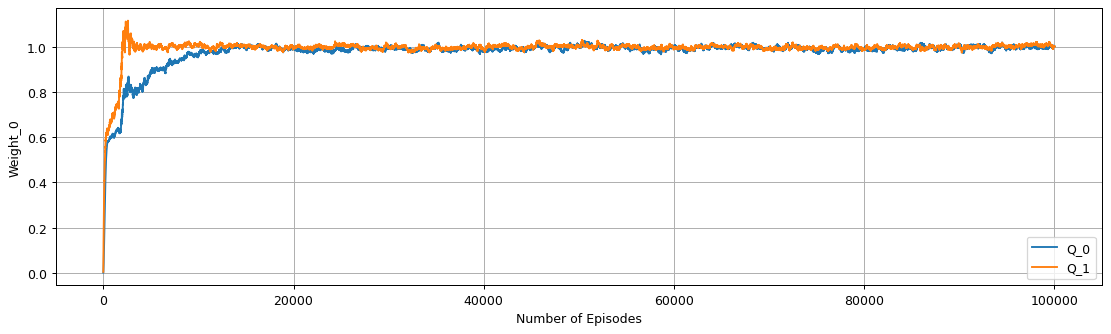

In [ ]:
figure(figsize=(15, 4), dpi=90)     
plt.grid(True)
plt.plot(np.linspace(1,episodes,episodes),weights_0[:,0],label='Q_0')
plt.plot(np.linspace(1,episodes,episodes),weights_0[:,1],label='Q_1')
plt.xlabel('Number of Episodes')
plt.ylabel('Weight_%d' %(0))
plt.legend()
plt.show()

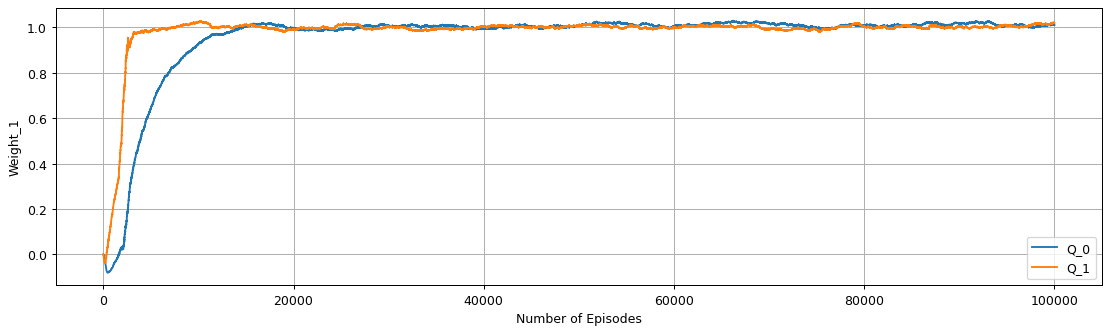

In [ ]:
figure(figsize=(15, 4), dpi=90)     
plt.grid(True)
plt.plot(np.linspace(1,episodes,episodes),weights_1[:,0],label='Q_0')
plt.plot(np.linspace(1,episodes,episodes),weights_1[:,1],label='Q_1')
plt.xlabel('Number of Episodes')
plt.ylabel('Weight_%d' %(1))
plt.legend()
plt.show()

### Extend to 10 period

In [ ]:
episodes = 50000
value_function = []
for i in range(T):
    value_function.append(Action_Value_Function_value(2, 0.01))
weights_0,weights_1,w_10=train_model_multi_Q(episodes,value_function,EPSILON,T_x=10,max_wealth = 1,random_start=True)

  0%|          | 0/50000 [00:00<?, ?it/s]

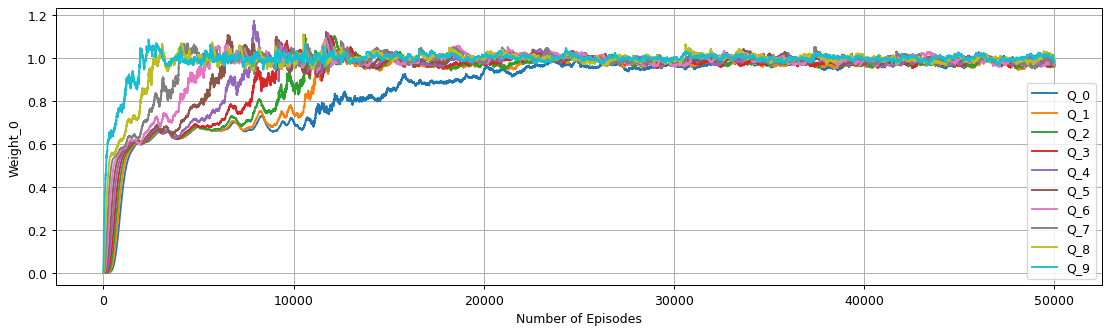

In [ ]:
figure(figsize=(15, 4), dpi=90)     
plt.grid(True)
for i in range(T):
    plt.plot(np.linspace(1,episodes,episodes),weights_0[:,i],label='Q_%d'%(i))
plt.xlabel('Number of Episodes')
plt.ylabel('Weight_%d' %(0))
plt.legend()
plt.show()

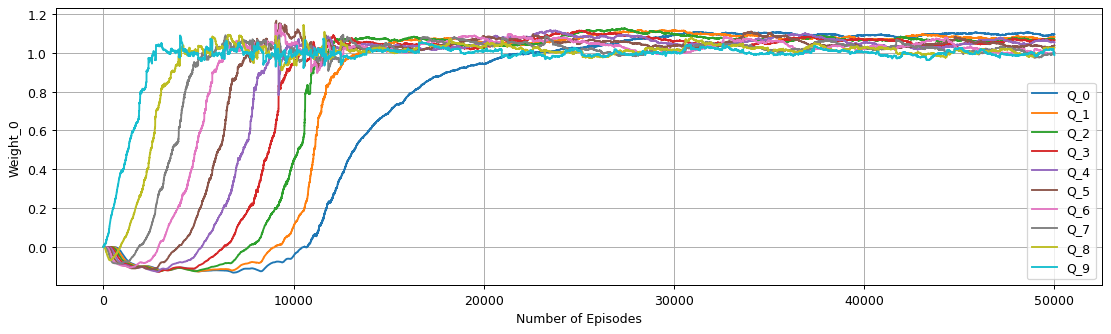

In [ ]:
figure(figsize=(15, 4), dpi=90)     
plt.grid(True)
for i in range(T):
    plt.plot(np.linspace(1,episodes,episodes),weights_1[:,i],label='Q_%d'%(i))
plt.xlabel('Number of Episodes')
plt.ylabel('Weight_%d' %(0))
plt.legend()
plt.show()

In [ ]:
#random choose t=5
value_function[4].weights

array([0.97872739, 1.05409839])

In [ ]:
#True value:
[(((1-Prob)/Prob * (RISK_FREE - BETA)/(ALPHA - RISK_FREE))**((ALPHA - RISK_FREE)/(ALPHA - BETA)) * Prob +((1-Prob)/Prob * \
            (RISK_FREE - BETA)/(ALPHA - RISK_FREE))**((BETA - RISK_FREE)/(ALPHA - BETA)) * (1-Prob))**5/RISK_AVERSION,
 
(1+RISK_FREE)**5*RISK_AVERSION]

[0.9745976659014347, 1.0510100501000001]

### Change global parameters to test Robustness

In [ ]:
Max_wealth = 5
ACTION_SPLIT = 100
ACTIONS = np.linspace(0,Max_wealth,ACTION_SPLIT+1) 

In [ ]:
episodes = 50000
value_function = []
for i in range(T):
    value_function.append(Action_Value_Function_value(2, 0.005))
weights_0,weights_1,w_10=train_model_multi_Q(episodes,value_function,EPSILON,T_x=10,max_wealth = 5,random_start=True)

  0%|          | 0/50000 [00:00<?, ?it/s]

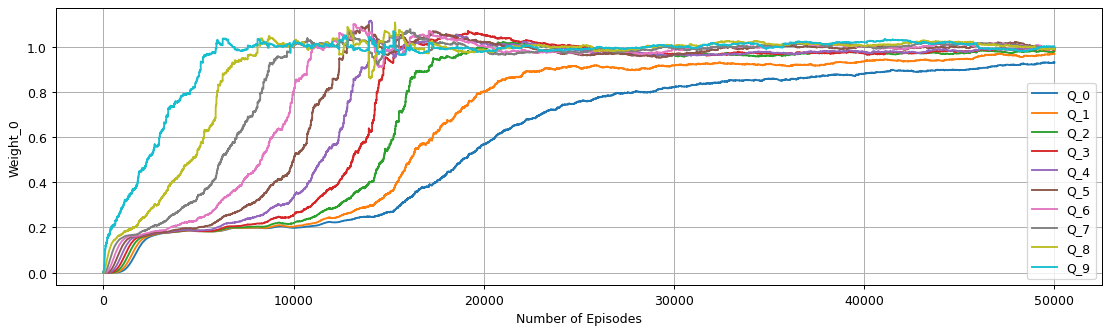

In [ ]:
figure(figsize=(15, 4), dpi=90)     
plt.grid(True)
for i in range(T):
    plt.plot(np.linspace(1,episodes,episodes),weights_0[:,i],label='Q_%d'%(i))
plt.xlabel('Number of Episodes')
plt.ylabel('Weight_%d' %(0))
plt.legend()
plt.show()

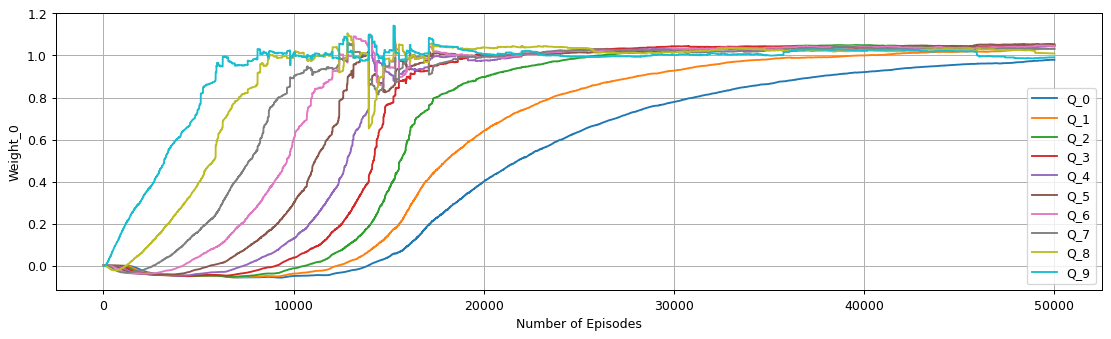

In [ ]:
figure(figsize=(15, 4), dpi=90)     
plt.grid(True)
for i in range(T):
    plt.plot(np.linspace(1,episodes,episodes),weights_1[:,i],label='Q_%d'%(i))
plt.xlabel('Number of Episodes')
plt.ylabel('Weight_%d' %(0))
plt.legend()
plt.show()

The multiple Q model works well with expanding the maximum wealth. However, due to the expoential part in the gradient, the maximum wealth could not set too high as it will occur math range error due to the randomness of intial wealth.

In [ ]:
value_function[4].weights

array([0.99023713, 1.048933  ])

In [ ]:
#True value:
[(((1-Prob)/Prob * (RISK_FREE - BETA)/(ALPHA - RISK_FREE))**((ALPHA - RISK_FREE)/(ALPHA - BETA)) * Prob +((1-Prob)/Prob * \
            (RISK_FREE - BETA)/(ALPHA - RISK_FREE))**((BETA - RISK_FREE)/(ALPHA - BETA)) * (1-Prob))**5/RISK_AVERSION,
 
(1+RISK_FREE)**5*RISK_AVERSION]

[0.9745976659014347, 1.0510100501000001]